In [1]:
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from IPython.display import Image 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
%matplotlib inline
%run evaluate.ipynb
sns.set_style("darkgrid")

C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
data = pd.read_csv("caravan.csv")
testdata = pd.read_csv("caravanTest.csv")

In [3]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_test = testdata.iloc[:, :-1]
y_test = testdata.iloc[:, -1]

In [4]:
X.head()

,Customer Subtype,Number of houses,Avg size household,Avg Age,Customer main type,Roman catholic,Protestant,Other religion,No religion,Married,...,Number of life insurances,Number of private accident insurance policies,Number of family accidents insurance policies,Number of disability insurance policies,Number of re policies,Number of surfboard policies,Number of boat policies,Number of bicycle policies,Number of property insurance policies,Number of social security insurance policies
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


## Univariate Selection

In [5]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

In [6]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [7]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs','Score']  

In [8]:
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                              Specs       Score
46                        Contribution car policies  380.691708
60                       Contribution boat policies  191.696446
0                                  Customer Subtype  190.696878
58                       Contribution fire policies  100.332586
29                                     Rented house   82.130521
63  Contribution social security insurance policies   80.693160
67                           Number of car policies   78.757821
15                             High level education   75.173970
81                          Number of boat policies   72.088379
30                                      Home owners   71.638337


In [9]:
featuresList = list(featureScores.nlargest(10,'Score')['Specs'])
featuresList

['Contribution car policies',
 'Contribution boat policies',
 'Customer Subtype',
 'Contribution fire policies',
 'Rented house',
 'Contribution social security insurance policies',
 'Number of car policies',
 'High level education',
 'Number of boat policies',
 'Home owners']

In [10]:
len(featuresList)

10

## Feature Importance

### 1.  RandomForestClassifier

In [11]:
model_1 = RandomForestClassifier(n_estimators= 100)
model_1.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

What is Random Forest? It consists of a large number of individual decision trees that operate as an ensemble. 
The fundamental concept behind random forest is a simple but powerful one — the wisdom of crowds.

Random forest takes advantage of this by allowing each individual tree to randomly sample from the dataset with replacement, resulting in different trees. This process is known as bagging.
Every sampling we randomly choose the subset of features and instances to build up a tree. 
After several times, the forest is constructed by 100 trees. 
And we collect the classification result from every tree, and then let the majority be our final decision. 

In [12]:
y_pred = model_1.predict(X_test)
# the threshold is equal to 0.5
evaluateResult(y_test, y_pred)

Accuracy: 0.93325
F1 score: 0.09491525423728814
Recall score: 0.058823529411764705


In [13]:
y_pred_prob = model_1.predict_proba(X_test)
y_pred = prob2binary(y_pred_prob, threshold = 0.3)

In [14]:
evaluateResult(y_test, y_pred)

Accuracy: 0.91025
F1 score: 0.1747126436781609
Recall score: 0.15966386554621848


AUC: 0.69


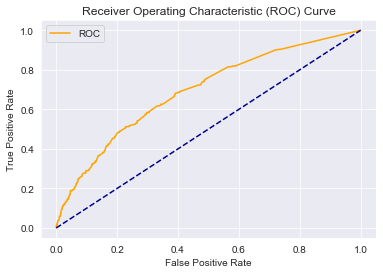

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
auc = roc_auc_score(y_test, y_pred_prob[:, 1])
print('AUC: %.2f' % auc)
plot_roc_curve(fpr, tpr)

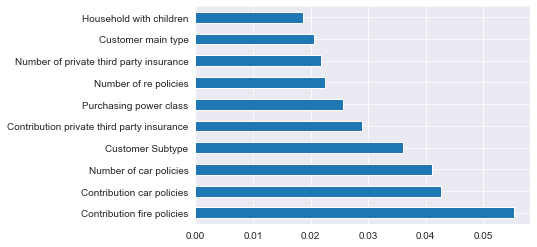

In [16]:
feat_importances = pd.Series(model_1.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [17]:
# Adding the important feature into the feature List 
RFList = list(feat_importances.nlargest(10).index)
for feature in RFList:
    if feature not in featuresList:
        featuresList.append(feature)

In [18]:
len(featuresList)

16

### 2. ExtraTreeClassifier

In [19]:
model_2 = ExtraTreesClassifier(n_estimators= 100)
model_2.fit(X,y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [20]:
y_pred = model_2.predict(X_test)
print("Recall rate:", recall_score(y_test, y_pred))

Recall rate: 0.08823529411764706


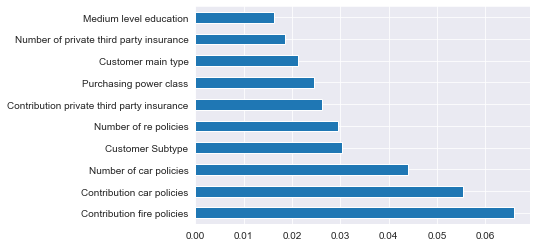

In [21]:
feat_importances = pd.Series(model_2.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [22]:
ETList = list(feat_importances.nlargest(10).index)
for feature in ETList:
    if feature not in featuresList:
        featuresList.append(feature)

In [23]:
len(featuresList)

17

## Correlation Matrix 

In [24]:
newX = X[featuresList]
newX.head()

,Contribution car policies,Contribution boat policies,Customer Subtype,Contribution fire policies,Rented house,Contribution social security insurance policies,Number of car policies,High level education,Number of boat policies,Home owners,Contribution private third party insurance,Purchasing power class,Number of re policies,Number of private third party insurance,Customer main type,Household with children,Medium level education
0,6,0,33,5,1,0,1,1,0,8,0,3,1,0,8,6,2
1,0,0,37,2,2,0,0,0,0,7,2,4,1,2,8,5,5
2,6,0,37,2,7,0,1,0,0,2,2,4,1,1,8,2,5
3,6,0,9,2,5,0,1,3,0,4,0,4,1,0,3,4,4
4,0,0,40,6,4,0,0,5,0,5,0,3,1,0,10,4,4


In [25]:
newData = [newX, y]
newData = pd.concat(newData, axis=1)
newData

,Contribution car policies,Contribution boat policies,Customer Subtype,Contribution fire policies,Rented house,Contribution social security insurance policies,Number of car policies,High level education,Number of boat policies,Home owners,Contribution private third party insurance,Purchasing power class,Number of re policies,Number of private third party insurance,Customer main type,Household with children,Medium level education,CARAVAN POLICY
0,6,0,33,5,1,0,1,1,0,8,0,3,1,0,8,6,2,0
1,0,0,37,2,2,0,0,0,0,7,2,4,1,2,8,5,5,0
2,6,0,37,2,7,0,1,0,0,2,2,4,1,1,8,2,5,0
3,6,0,9,2,5,0,1,3,0,4,0,4,1,0,3,4,4,0
4,0,0,40,6,4,0,0,5,0,5,0,3,1,0,10,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,6,0,36,3,9,0,1,2,0,0,2,3,1,1,8,2,5,0
5818,0,0,35,5,3,0,0,0,0,6,0,5,1,0,8,5,0,0
5819,6,0,33,4,7,0,1,0,0,2,2,3,1,1,8,4,1,1
5820,6,0,34,0,2,0,1,0,0,7,0,6,0,0,8,5,2,0


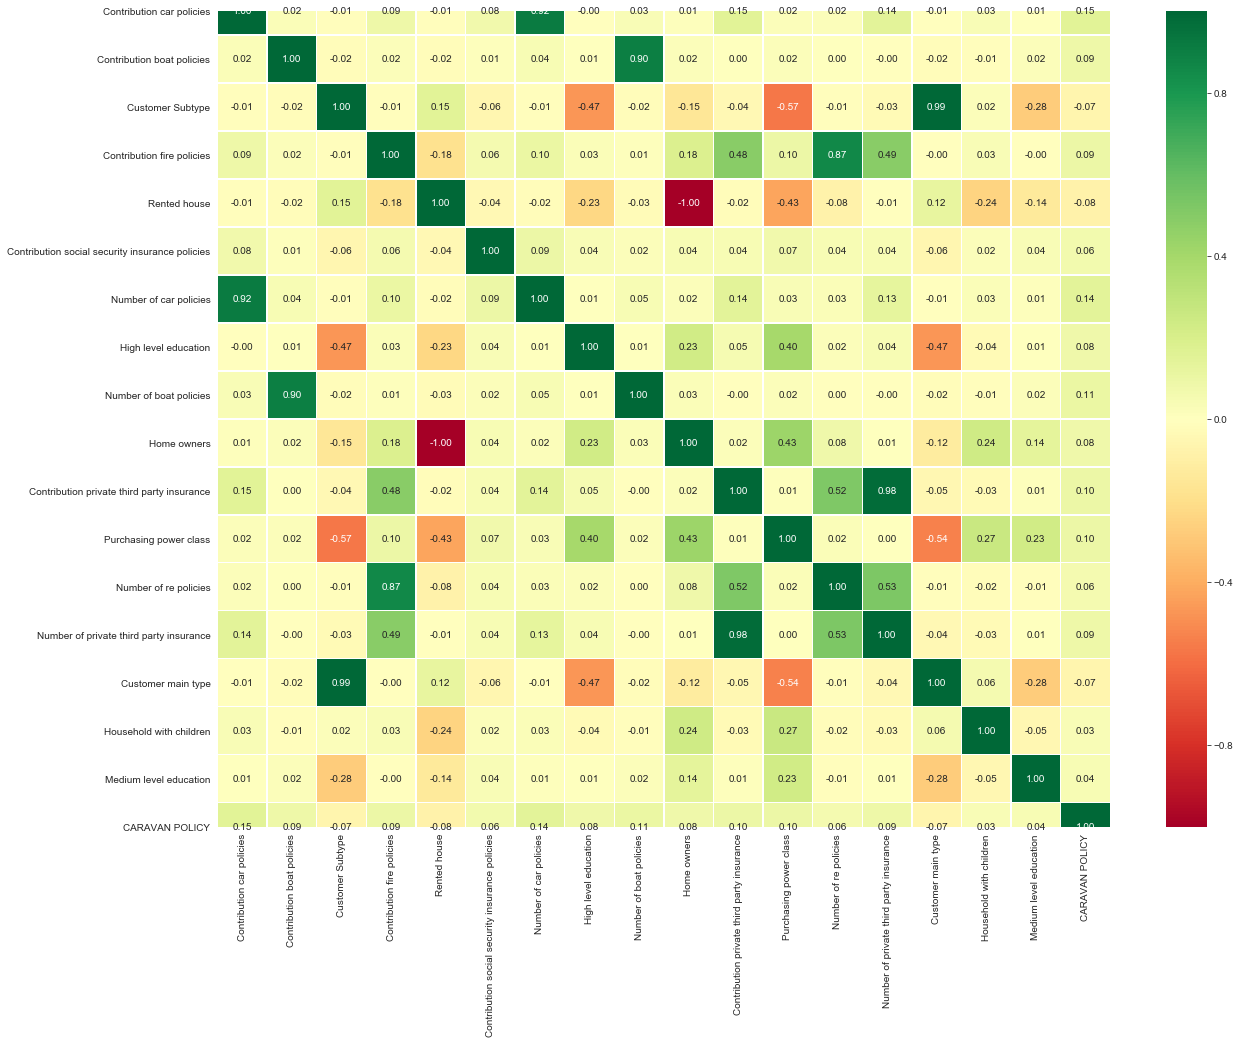

In [26]:
#plot heat map
plt.figure(figsize=(20,15))
g=sns.heatmap(newData.corr(), annot=True, cmap="RdYlGn", linewidths=.5, fmt=".2f")

From the above heatmap, we found out there are some features remaining highly positive correlation or negative correlation with each other. 

For example, the correlation coefficient between "Home Owner" and "Rented House" is -1, which means we could just include one of the feature. (We choose Home Owner as our remaining feature.)

For another example, the correlation coefficient between "Number of private third party insurance" and "Contribution private third party insurance" is 0.98. (We choose "Contribution private third party insurance" since it has 0.98 on the variance and "Number of private third party insurance" has 0.12 on the variance.)

In [90]:
featuresList

['Contribution car policies',
 'Contribution boat policies',
 'Customer Subtype',
 'Contribution fire policies',
 'Rented house',
 'Contribution social security insurance policies',
 'Number of car policies',
 'High level education',
 'Number of boat policies',
 'Home owners',
 'Contribution private third party insurance',
 'Purchasing power class',
 'Number of re policies',
 'Number of private third party insurance',
 'Customer main type',
 'Household with children',
 'Medium level education']

In [91]:
# exclude one from the high correlation features pairs
newfeaturesList = []
deleteList = ['Rented House', 'Number of private third party insurance', 'Number of boat policies', 
              'Number of re policies', 'Number of car policies', 'Customer main type']
for feature in featuresList:
    if feature not in deleteList:
        newfeaturesList.append(feature)

In [92]:
newfeaturesList

['Contribution car policies',
 'Contribution boat policies',
 'Customer Subtype',
 'Contribution fire policies',
 'Rented house',
 'Contribution social security insurance policies',
 'High level education',
 'Home owners',
 'Contribution private third party insurance',
 'Purchasing power class',
 'Household with children',
 'Medium level education']

In [93]:
len(newfeaturesList)

12

# Build up a decision tree 

In [31]:
X_train = data[newfeaturesList]
y_train = y

model = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=10)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [32]:
X_test = testdata[newfeaturesList]
y_pred = model.predict(X_test)
evaluateResult(y_test, y_pred)

Accuracy: 0.93875
F1 score: 0.02390438247011952
Recall score: 0.012605042016806723


AUC: 0.70


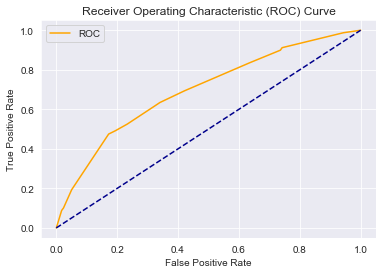

In [33]:
y_pred_prob = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
auc = roc_auc_score(y_test, y_pred_prob[:, 1])
print('AUC: %.2f' % auc)
plot_roc_curve(fpr, tpr)

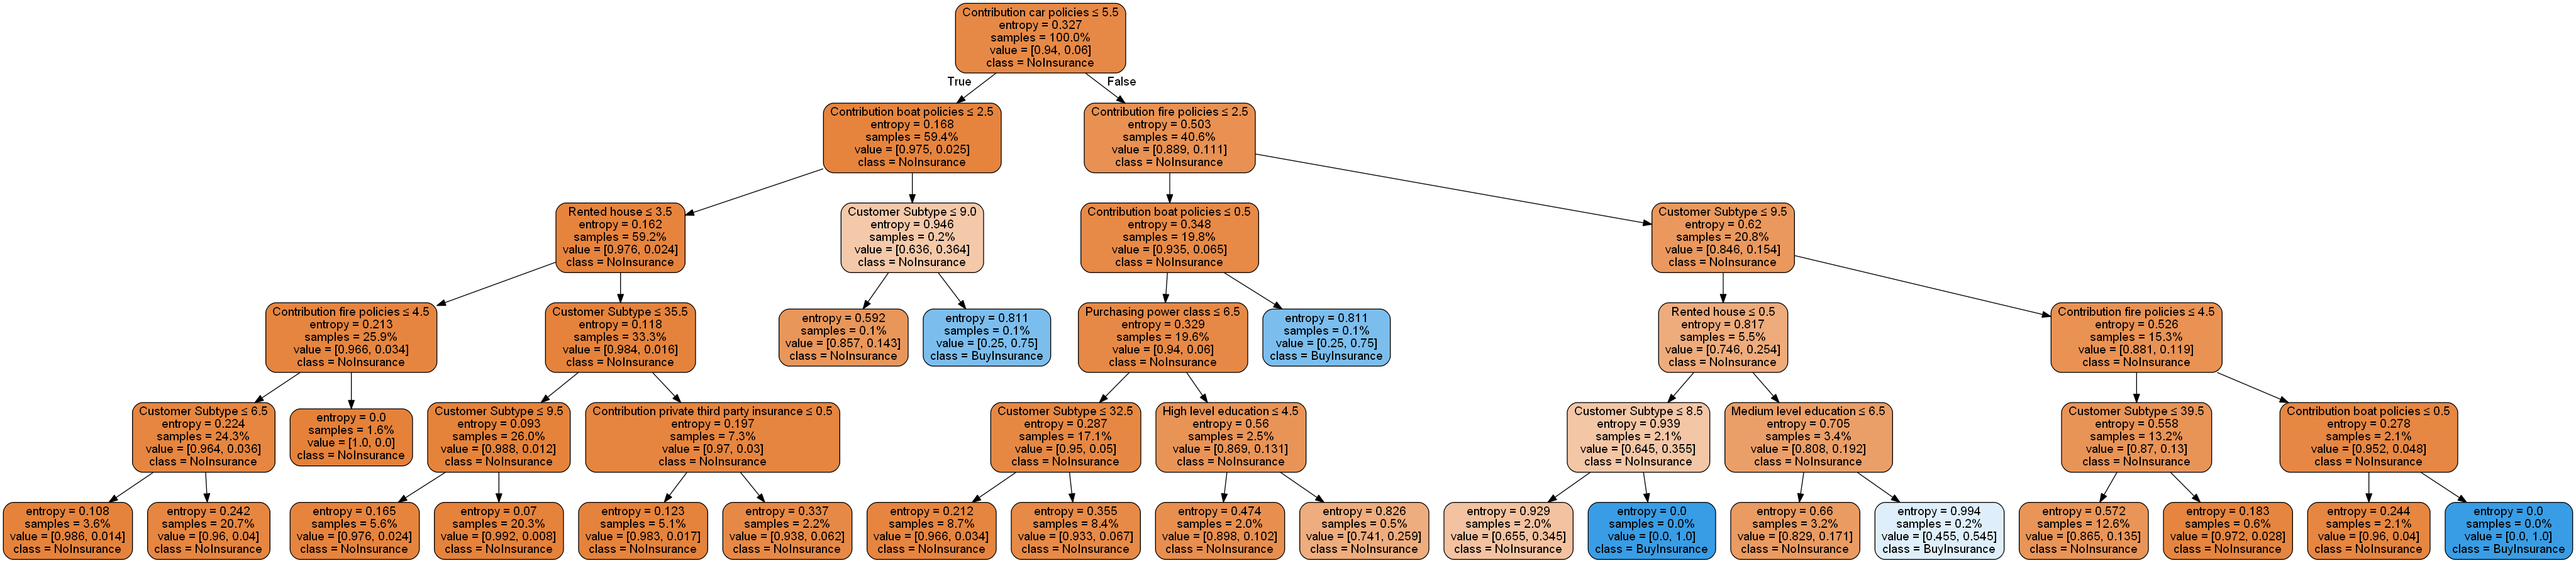

In [33]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = newfeaturesList,
                class_names=['NoInsurance','BuyInsurance'], 
               proportion = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('pic/DTree_1.png')
# Image(graph.create_png())
Image(graph.create_png())

In [34]:
x_axis = []
list_cv_acc = []
list_train_acc = []
for i in range(10, 1000 , 10):
    model = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_split = i)
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'accuracy')
    list_cv_acc.append(scores.mean())
    
    y_pred = model.predict(X_train)
    training_acc = accuracy_score(y_train, y_pred)
    list_train_acc.append(training_acc)
    x_axis.append(i)

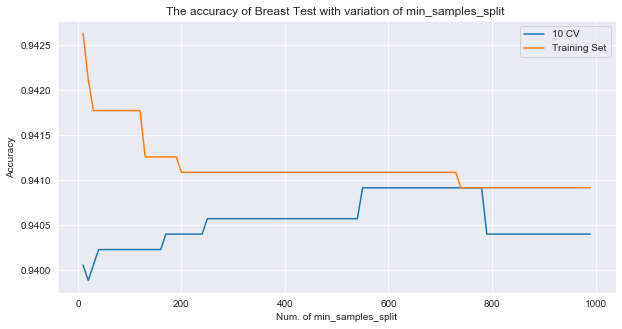

In [35]:
plt.figure(figsize=(10,5))  
plt.plot(x_axis, list_cv_acc, label='10 CV')
plt.plot(x_axis, list_train_acc, label='Training Set')
plt.title("The accuracy of Breast Test with variation of min_samples_split ")
plt.xlabel("Num. of min_samples_split")
plt.ylabel("Accuracy")
plt.legend()

In [36]:
list_diff = [train_acc - cv_acc for cv_acc, train_acc in zip(list_cv_acc, list_train_acc)]
index_min = np.argmin(list_diff)*10+10
index_min

740

We see the accuracy converge when the number of min_sample_leaf is equal to 30. Therefore, we rebuild a new decision tree with min_sample_leaf equals to 30. 

In [37]:
modelDT = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split = index_min)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=740,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

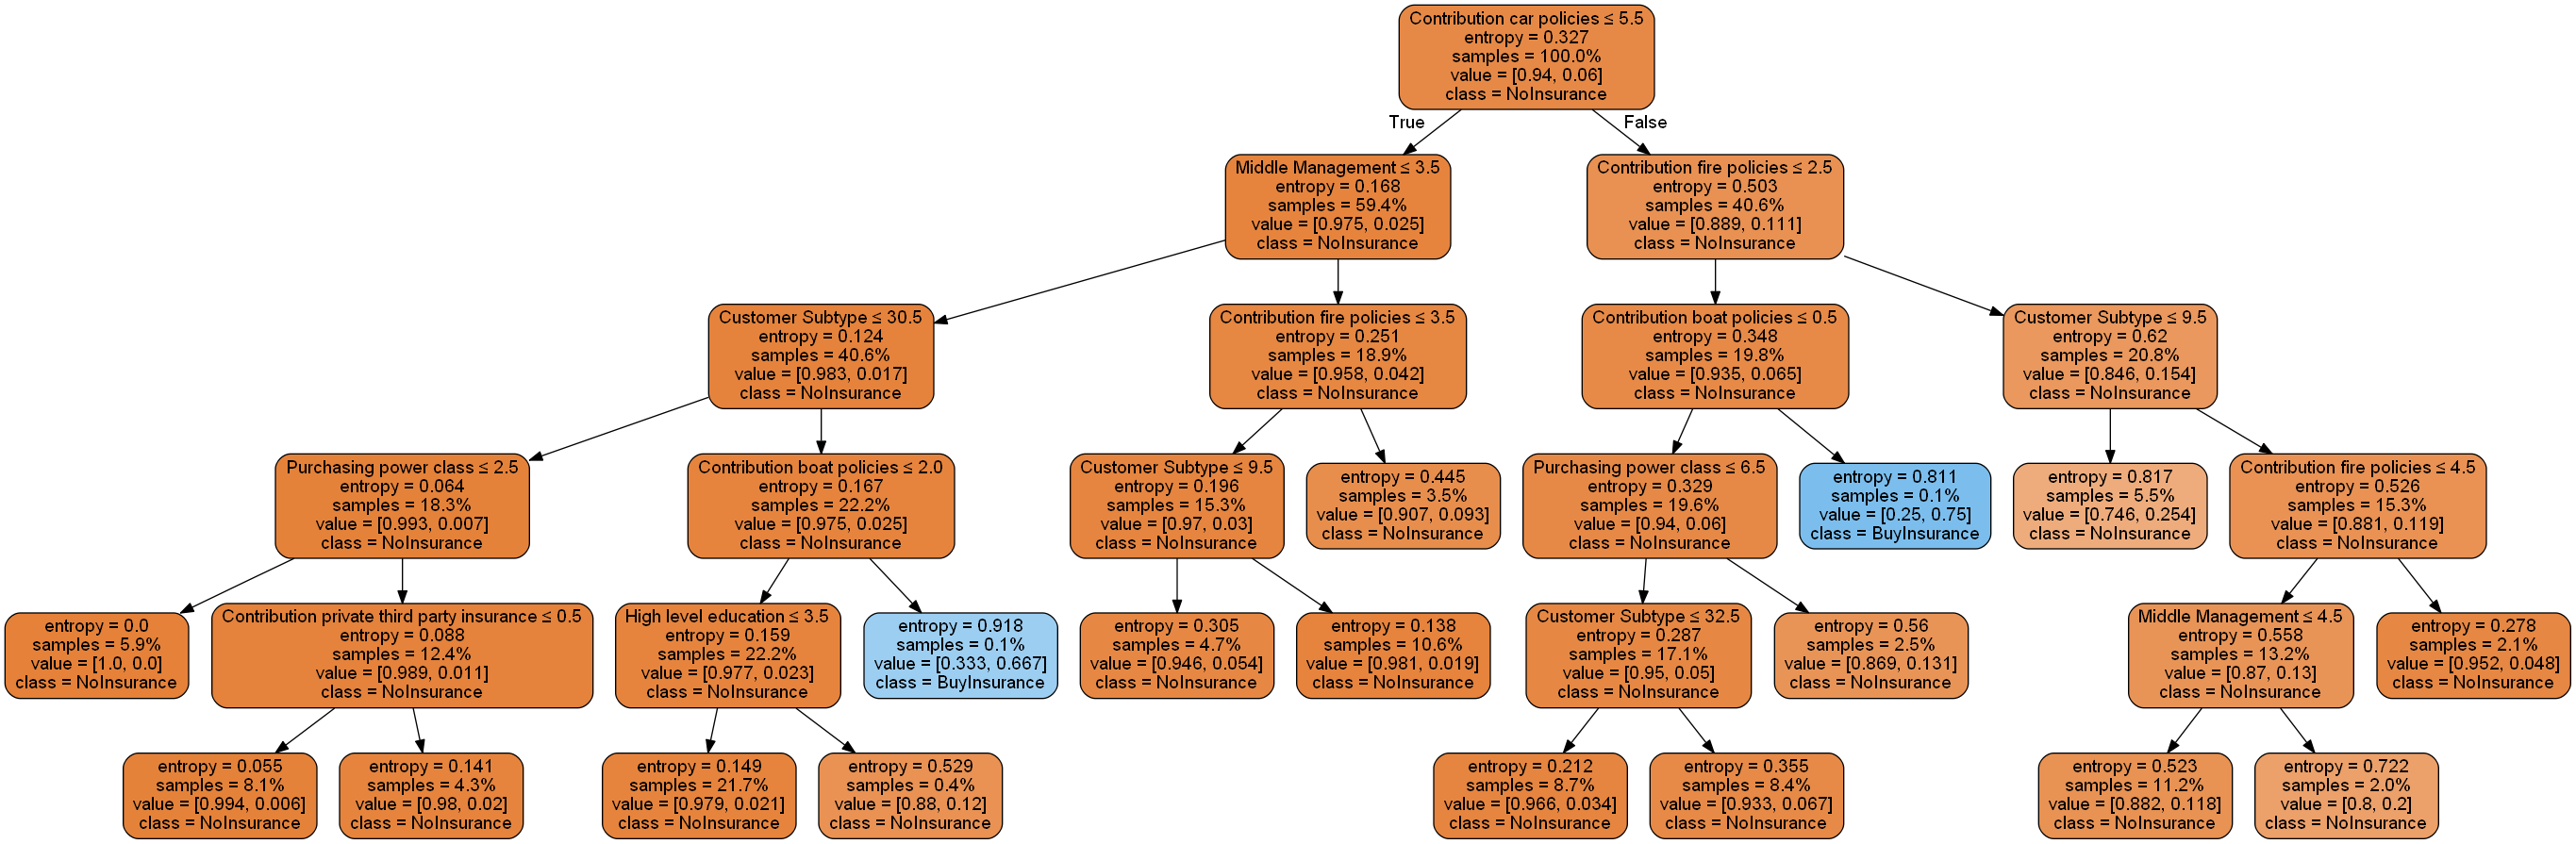

In [57]:
dot_data = StringIO()
export_graphviz(modelDT, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = newfeaturesList,
                class_names=['NoInsurance','BuyInsurance'],
               proportion = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('pic/DTree_2.png')
# Image(graph.create_png())
Image(graph.create_png())

In [38]:
X_test = testdata[newfeaturesList]
y_pred = modelDT.predict(X_test)
evaluateResult(y_test, y_pred)

Accuracy: 0.94025
F1 score: 0.008298755186721992
Recall score: 0.004201680672268907


AUC: 0.70


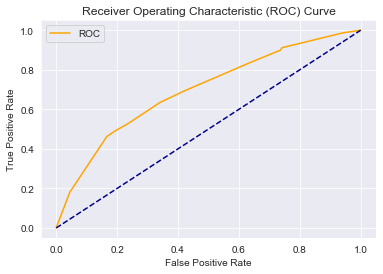

In [39]:
y_pred_prob = modelDT.predict_proba(X_test)
fpr_DT, tpr_DT, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
auc = roc_auc_score(y_test, y_pred_prob[:, 1])
print('AUC: %.2f' % auc)
plot_roc_curve(fpr_DT, tpr_DT)

# Random Forest

We re-run the RandomForestClassifier again to see whether the accuracy has improve or not. 

In [40]:
modelRF = RandomForestClassifier(n_estimators= 100, max_depth=5, min_samples_split = index_min)
modelRF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=740,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
X_test = testdata[newfeaturesList]
y_pred = modelRF.predict(X_test)
evaluateResult(y_test, y_pred)

Accuracy: 0.9405
F1 score: 0.0
Recall score: 0.0


C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC: 0.72


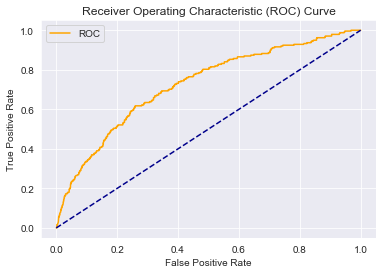

In [42]:
y_pred_prob = modelRF.predict_proba(X_test)
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
auc = roc_auc_score(y_test, y_pred_prob[:, 1])
print('AUC: %.2f' % auc)
plot_roc_curve(fpr_RF, tpr_RF)

# SVM classifier

In [43]:
modelSVM = SVC(kernel='rbf', random_state=0, gamma = 'auto', probability=True)
modelSVM.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [44]:
y_pred = modelSVM.predict(X_test)
evaluateResult(y_test, y_pred)

Accuracy: 0.94
F1 score: 0.0
Recall score: 0.0


AUC: 0.56


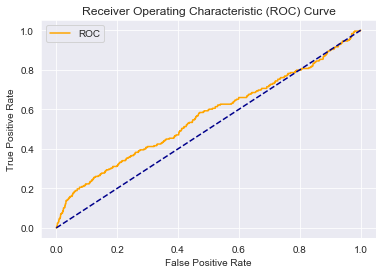

In [45]:
y_pred_prob = modelSVM.predict_proba(X_test)
fpr_SVM, tpr_SVM, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
auc = roc_auc_score(y_test, y_pred_prob[:, 1])
print('AUC: %.2f' % auc)
plot_roc_curve(fpr_SVM, tpr_SVM)

# Naive Baysian Classifier

In [46]:
modelNB = GaussianNB()
modelNB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [47]:
y_pred = modelNB.predict(X_test)
evaluateResult(y_test, y_pred)

Accuracy: 0.92475
F1 score: 0.10149253731343283
Recall score: 0.07142857142857142


AUC: 0.69


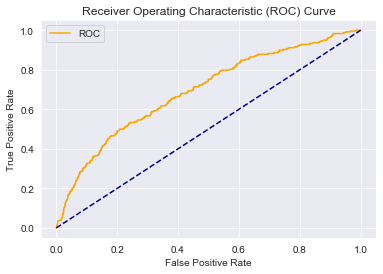

In [48]:
y_pred_prob = modelNB.predict_proba(X_test)
fpr_NB, tpr_NB, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
auc = roc_auc_score(y_test, y_pred_prob[:, 1])
print('AUC: %.2f' % auc)
plot_roc_curve(fpr_NB, tpr_NB)

# ANN

In [50]:
%run ANN.ipynb
modelANN = ANNclf(indput_dim = X_train.shape[1], dropout=0.2)
modelANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
modelANN.fit(X_train, y_train, batch_size=50, epochs=10, verbose=1)

Epoch 1/10
5822/5822 [==============================] - 1s 165us/step - loss: 0.4715 - acc: 0.9399
Epoch 2/10
5822/5822 [==============================] - 0s 36us/step - loss: 0.2437 - acc: 0.9402
Epoch 3/10
5822/5822 [==============================] - 0s 32us/step - loss: 0.2358 - acc: 0.9402
Epoch 4/10
5822/5822 [==============================] - 0s 32us/step - loss: 0.2340 - acc: 0.9402
Epoch 5/10
5822/5822 [==============================] - 0s 31us/step - loss: 0.2296 - acc: 0.9402
Epoch 6/10
5822/5822 [==============================] - 0s 31us/step - loss: 0.2279 - acc: 0.9402
Epoch 7/10
5822/5822 [==============================] - 0s 31us/step - loss: 0.2218 - acc: 0.9402
Epoch 8/10
5822/5822 [==============================] - 0s 32us/step - loss: 0.2176 - acc: 0.9402
Epoch 9/10
5822/5822 [==============================] - 0s 31us/step - loss: 0.2207 - acc: 0.9402
Epoch 10/10
5822/5822 [==============================] - 0s 37us/step - loss: 0.2152 - acc: 0.9402


4000/4000 [==============================] - 0s 35us/step
AUC: 0.67


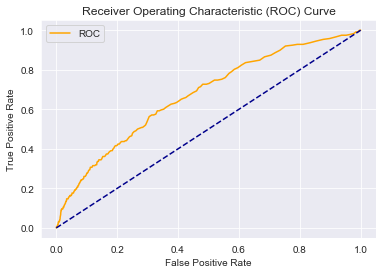

In [51]:
y_pred_prob = np.round(modelANN.predict(X_test, verbose=1), 3).reshape(-1)
fpr_ANN, tpr_ANN, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.2f' % auc)
plot_roc_curve(fpr_ANN, tpr_ANN)

# Plot all the classifier performance

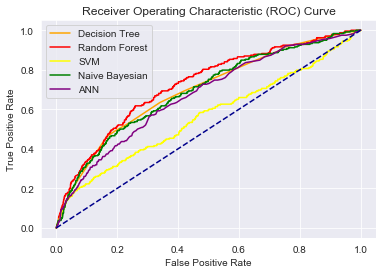

In [52]:
plt.plot(fpr_DT, tpr_DT, color='orange', label='Decision Tree')
plt.plot(fpr_RF, tpr_RF, color='red', label='Random Forest')
plt.plot(fpr_SVM, tpr_SVM, color='yellow', label='SVM')
plt.plot(fpr_NB, tpr_NB, color='green', label='Naive Bayesian')
plt.plot(fpr_ANN, tpr_ANN, color='purple', label='ANN')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig("pic/ROC.png")
plt.show()

# Choose top 800 cases by Random Forest

In [126]:
y_pred_prob = np.round(modelANN.predict(X_test, verbose=1), 3).reshape(-1)
y_pred_pos_prob = y_pred_prob
df_y_pred_pos_prob = pd.DataFrame({'y_pred_pos_prob': y_pred_pos_prob})

4000/4000 [==============================] - 0s 10us/step


In [127]:
testdata_prob = pd.concat([testdata, df_y_pred_pos_prob] , axis=1)
testdata_prob.head()

,Customer Subtype,Number of houses,Avg size household,Avg Age,Customer main type,Roman catholic,Protestant,Other religion,No religion,Married,...,Number of family accidents insurance policies,Number of disability insurance policies,Number of re policies,Number of surfboard policies,Number of boat policies,Number of bicycle policies,Number of property insurance policies,Number of social security insurance policies,CARAVAN POLICY,y_pred_pos_prob
0,33,1,4,2,8,0,6,0,3,5,...,0,0,1,0,0,0,0,0,0,0.033
1,6,1,3,2,2,0,5,0,4,5,...,0,0,1,0,0,0,0,0,1,0.150
2,39,1,3,3,9,1,4,2,3,5,...,0,0,1,0,0,0,0,0,0,0.080
3,9,1,2,3,3,2,3,2,4,5,...,0,0,1,0,0,0,0,0,0,0.152
4,31,1,2,4,7,0,2,0,7,9,...,0,0,1,0,0,0,0,0,0,0.020


In [128]:
testdata_sort = testdata_prob.sort_values(by=['y_pred_pos_prob'], ascending=False)

In [129]:
columnShow = ['Contribution car policies', 'Contribution boat policies', 
              'Customer Subtype', 'Contribution fire policies', 
             'CARAVAN POLICY', 'y_pred_pos_prob']

In [130]:
top800 = testdata_sort.iloc[:800, :]

In [131]:
sum(top800['CARAVAN POLICY'])
hitrate = sum(top800['CARAVAN POLICY'])/800
hitrate

0.11875

In [132]:
print("Hit rate: %.2f" %(hitrate*100), "%")

Hit rate: 11.88 %
